## PINNs baseline (by DeepXDE)

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import deepxde as dde
import numpy as np
print("NumPy version:", np.__version__)
# Backend pytorch
import torch
import numpy as np
import datetime, os
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


NumPy version: 1.26.4


### Get data

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
    
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).squeeze()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

In [3]:
# This function takes in a folder path with the DIB csv files and returns a list of dataframes with data
# from the CSV files
def getCSV(folder_path):
    files = []
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    for file in csv_files:
        file_name = os.path.splitext(file)[0]
        file_path = os.path.join(folder_path, file)
        dataframe = pd.read_csv(file_path, skiprows=range(15))
        files.append(dataframe)
    return files

In [4]:
#This function defines the Cottrell Equation which is Fick's second law of diffusion solved
# for specific boundary conditions for a planar electrode
def Cottrell_eq(t,n,D,F,A,i):
    return i/(n*F*A*(D**(1/2))/((np.pi**(1/2))*t**(1/2)))

def Nernst_eq(E,E0, n, F, R, T):
    #return U+((R*T/(n*F))*np.log((1-x)/x))+V_ni
    #return 1/(1+np.exp(-n*F*(E-E0)/(R*T))) #return x, concentration of reduced species
    return np.exp(E0-E)*(n*F/(R*T)) #return Q, [red]/[ox], = [li+][C6]/[LiC6] at anode

In [5]:
folder_path=r"./Data/DIB/DIB_Data/.csvfiles/Capacity_Check/80per_Cells_Capacity_Check_08122021_080cycle"
files = getCSV(folder_path)

In [6]:
n = 1 #number of electrons transferred per ion
A = 1 #surface area of electrode
D = 2.5*10**(-6) #diffusion coefficient of LiPF6 in EC:DMC, cm^2/s
gas_const = 8.314 #gas constant
T = 25+273.15 #temperature
E0 = 3.7

In [7]:
# Problem parameter
c0 = 1.0 # initial concentration
D = 1.5*10**(-11) # solid-phase diffusion coefficient
R = 1.0
t = 1.0 # time 
It = 1.0 # current at time t
A = 1.0 # battery sheet area
L = 1.0 # thickness of positive/negative electrode
eps = 0.5 # solid phase volume fraction of each electrode
a = 3*eps/R # specific interfacial area
F = 96485 #Faraday's constant, C/mol
delta = It*R/(A*L*F*D*a*c0)

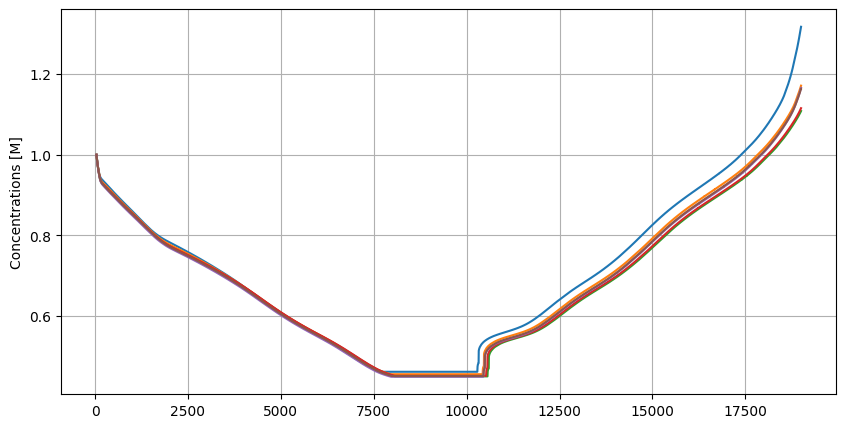

In [8]:
# Calculating total concentration in electrode using Nernst equation
fig2 = plt.figure(figsize=(10, 5))
Q=[]
li_conc=[]
for i in range(len(files)):
    Q.append(Nernst_eq(files[i].iloc[40:19000,7].astype(float), E0, n, F, gas_const,T))
    lic6_conc = Q[i].iloc[0]
    c6_conc = 1
    li_conc.append(Q[i]*c6_conc/lic6_conc)
    plt.plot(li_conc[i])


plt.ylabel('Concentrations [M]')
plt.grid()

In [9]:
Q=[]
li_conc=[]
time = []
for i in range(len(files)):
    Q.append(Nernst_eq(files[i].iloc[40:19000,7].astype(float), E0, n, F, R,T))
    lic6_conc = Q[i].iloc[0]
    c6_conc = 1
    li_conc.append(Q[i]*c6_conc/lic6_conc)
    time.append(files[i].iloc[40:19000,3].astype(float))

combined = list(zip(time, li_conc))
combined0 = np.array(combined[0])

time = np.array(time)
li_conc = np.array(li_conc)

time0 = time[0]
time0 = time0[:100]
li_conc0 = li_conc[0]
li_conc0 = li_conc0[:100]

In [10]:
tau0 = D * time0 / (R**2)
tau_max = np.max(tau0)

In [11]:
tau_max

2.8637205e-08

### PINNs model

In [12]:
# xt = (x, t)
def pde(xt, c):
    # Most backends
    dc_x = dde.grad.jacobian(c, xt, j=0)
    dc_t = dde.grad.jacobian(c, xt, j=1)
    dc_xx = dde.grad.hessian(c, xt, j=0)
    # Backend pytorch
    return (
        dc_t
        - 2 * dc_x / (xt[:, 0] + 1e-6)
        - dc_xx
    )

def boundary_l(xt, on_boundary):
    return on_boundary and dde.utils.isclose(xt[0], 0)

def boundary_r(xt, on_boundary):
    return on_boundary and dde.utils.isclose(xt[0], 1)

In [13]:
# Concentration from dataset
n_obs = time0.shape
observe_xt = np.vstack((np.ones(n_obs), np.array(time0))).T
observe_c = li_conc0.reshape(-1,1)
observe_pts = dde.icbc.PointSetBC(observe_xt, observe_c, component=0)

Compiling model...
'compile' took 0.562296 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.23e+09, 1.19e-02, 1.13e+00]    [4.47e+07, 1.19e-02, 1.13e+00]    []  
500       [2.67e+05, 3.08e-06, 4.31e-01]    [3.73e+03, 3.08e-06, 4.31e-01]    []  

Best model at step 500:
  train loss: 2.67e+05
  test loss: 3.73e+03
  test metric: []

'train' took 3.557054 s



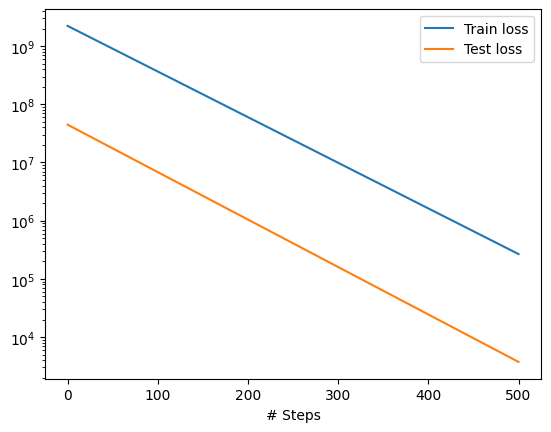

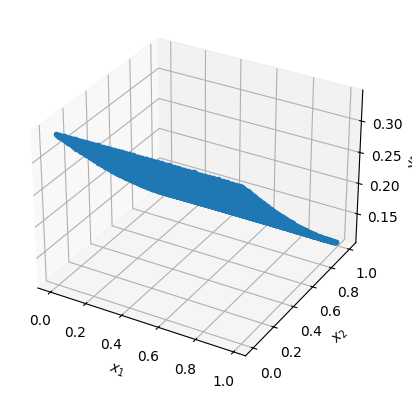

In [14]:
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc_l = dde.icbc.NeumannBC(geomtime, lambda X: 0.0, boundary_l)
# bc_r = dde.icbc.NeumannBC(geomtime, lambda X: delta, boundary_r)

ic = dde.icbc.IC(geomtime, lambda X: 1.0, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_xt,
    num_test=10000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=500)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)